# Additional Task (CMS and E2E): Vision Transformers for End-to-End Particle Identification with the CMS Experiment
### Chenguang Guan

ViT have been applied to task 1 yet. In this additional task, we will discuss ViT (with more epoches) and Swin Transformer.

## Workflow of ViT

In the original Transformer for NLP, there are both attention-based encoders and decoders.

However, there is only attention-based encoder in ViT. The ViT introduces patch embedding to transform 2D image-patches to flatten embedding vectors ("Images to Words"), while they also develop some other positional embedding including 2-D/relative/learnable embedding beyond the 1-D positional embedding in NLP Transformer. Finally, they borrows the idea of class token from $\textbf{BERT}$ to classify the images.

1. Patch Embedding: $\mathbf{x} \in \mathbb{R}^{H \times W \times C}\rightarrow\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$

2. Class Token: Borrow from the BERT model.

3. Position Embeidding: learnable 1D postion embeddings, 2D postion embeddings, etc.

4. Incorporating position information in the model: Add before feeding into the transformer encoder; Add before each encoder block; Add before each encoder block (shared weights).

5. Transformer Encoder Block: same as NLP transformer.
MLP for the class token

## Workflow of Swin Transformer

The differences between original ViT and Swin Transformer are their attetion mechanism. The attention mechanism of Swin Transformer is hierarchical attention.

With the coarse graining going on, the size of each patch is getting larger (similar with Renormalization Group in Physics).

$\left(H_{\text{Patch}}, W_{\text{Patch}}\right)\rightarrow \left(H_{2\text{Patch}}, 2W_{\text{Patch}}\right)\rightarrow \left(4H_{\text{Patch}}, 4W_{\text{Patch}}\right)\rightarrow ...$

## I. Preparation

In [ ]:
!/opt/bin/nvidia-smi

Sun Apr  2 14:20:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp --recursive "/content/gdrive/MyDrive/CMS_data" .

In [ ]:
import h5py
import torch

import numpy as np

from torch.utils.data import Dataset, DataLoader

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms


import random
import time

from sklearn import metrics

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is:", device)

Device is: cuda


## II. Dataset

In [ ]:
shuffle_list = np.arange(0, 249000*2, 1) 
random.shuffle(shuffle_list)

In [ ]:
np.save("/content/gdrive/MyDrive/CMS_data/shuffle_list.npy",shuffle_list)

In [ ]:
shuffle_list = np.load("/content/gdrive/MyDrive/CMS_data/shuffle_list.npy")

In [ ]:
f1 = h5py.File(r'/content/CMS_data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
f2 = h5py.File(r'/content/CMS_data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
total_X = np.concatenate( (f1["X"][:], f2["X"][:] ), axis=0 )
total_y = np.concatenate( (f1["y"][:], f2["y"][:] ), axis=0 )

In [ ]:
total_X = total_X[shuffle_list]
total_y = total_y[shuffle_list].astype(int)

In [ ]:
total_X = np.concatenate( (total_X, total_X[:,:,:,:1]), axis = 3)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, shuffle_list, train=True, transform=None, target_transform=None):
        global total_X, total_y
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.length = len(total_X)
        self.train_length = int( self.length * 9/10)
        self.test_length = int( self.length / 10)
            
    def __len__(self):
        if self.train:
            return self.train_length
        else:
            return self.test_length
    
    def __getitem__(self,idx):
        if self.train:
            image, label = total_X[idx], total_y[idx]
        else:
            image, label = total_X[idx + self.train_length], total_y[idx + self.train_length]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
my_transform_normal = transforms.ToTensor()

In [ ]:
my_transform_pretrained = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])

In [ ]:
my_transform_single_channel = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)),
                                   transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
    ])

In [ ]:
train_set = MyDataset(shuffle_list=shuffle_list, train=True, transform=my_transform_pretrained)
train_loader =  DataLoader(train_set, batch_size=200, shuffle=True)

In [ ]:
test_set = MyDataset(shuffle_list=shuffle_list, train=False, transform=my_transform_pretrained)
test_loader =  DataLoader(test_set, batch_size=200, shuffle=False)

## III. Train and Test Loop

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    running_loss = 0.
    #total_sample = 0
    for batch_i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Compute prediction and loss
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        num_batch_print = 200
        if batch_i % num_batch_print == num_batch_print - 1:
            current = (batch_i + 1) * len(inputs)
            print(f'batch: [{batch_i + 1:5d}], loss: {running_loss / num_batch_print:.3f}')
            print(f'temporary loss: {loss.item():>7f} | [{current:>5d}/{size:>5d}]')
            running_loss = 0

In [ ]:
def test_loop_Entropy(dataloader, model, loss_fn):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, correct = 0, 0
    total = 0
    
    with torch.no_grad():
        for data in dataloader:
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            
            # classify which class the output in
            _, predicted = torch.max(outputs.data, 1)
            #_, labels_value = torch.max(labels.data, 1)
            
            # obtain the statistics of test loss and correctness
            test_loss += loss_fn(outputs, labels).item()
            correct += (predicted == labels).sum().item() 
            #correct += (predicted == labels_value).sum().item() 
            total += labels.size(0)

    print(f"Test Error: \n Accuracy: {(100 * correct / total):>0.1f}%")
    print(f"Avg loss: {test_loss / num_batches:>8f} \n")

In [ ]:
def test_loop_prob(dataloader, model):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    total_prob = list()
    total_label = list()
    i = 0
    with torch.no_grad():
        for (i, data) in enumerate(dataloader):
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)[:, 1]
            
            total_prob += torch.Tensor.cpu(probabilities).numpy().tolist()
            
            total_label += torch.Tensor.cpu(labels).numpy().tolist()
            
            if i % 25 == 0:
                print(f"Process: {i/num_batches*100}\%")
    return np.array(total_prob), np.array(total_label)

## III. ViT

Batch size: 200

Training on: A100 GPU

Learning Rate: 1e-3 (5 epoch), 1e-4 (3 epoch)

Optimizer: Adam

Test Accuracy ~ 72.5% (underfit, not well-trained yet) 

Time: The training of ViT is very slow and computational expensive. Each epoch will cost about 1 hour on A100 GPU.

In [ ]:
model_ViT = torchvision.models.vit_b_16().to(device)
in_features = model_ViT.heads.head.in_features
model_ViT.heads.head = nn.Linear(in_features, 2, device=device)

### Training and Accuracy (ViT)

In [ ]:
lr_list = [1e-3]
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ViT.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ViT, criterion, optimizer)
    test_loop_Entropy(test_loader, model_ViT, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.746
temporary loss: 0.693299 | [40000/448200]
batch: [  400], loss: 0.699
temporary loss: 0.691458 | [80000/448200]
batch: [  600], loss: 0.684
temporary loss: 0.674643 | [120000/448200]
batch: [  800], loss: 0.670
temporary loss: 0.669602 | [160000/448200]
batch: [ 1000], loss: 0.657
temporary loss: 0.672156 | [200000/448200]
batch: [ 1200], loss: 0.645
temporary loss: 0.625073 | [240000/448200]
batch: [ 1400], loss: 0.637
temporary loss: 0.641013 | [280000/448200]
batch: [ 1600], loss: 0.628
temporary loss: 0.642921 | [320000/448200]
batch: [ 1800], loss: 0.625
temporary loss: 0.601461 | [360000/448200]
batch: [ 2000], loss: 0.617
temporary loss: 0.572669 | [400000/448200]
batch: [ 2200], loss: 0.615
temporary loss: 0.570742 | [440000/448200]
Test Error: 
 Accuracy: 68.4%
Avg loss: 0.602019 

Done!
Time Consumption 3339.724937438965


In [ ]:
path = "./gdrive/MyDrive/CMS_model/ViT_task1_weights.pth"
torch.save(model_ViT.state_dict(), path)

In [ ]:
path = "./gdrive/MyDrive/CMS_model/ViT_task1_weights.pth"
model_ViT.load_state_dict( torch.load(path) )

<All keys matched successfully>

In [ ]:
path2 = "./gdrive/MyDrive/CMS_model/ViT_task1_weights_02.pth"
lr_list = [1e-3] * 4
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ViT.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ViT, criterion, optimizer)
    test_loop_Entropy(test_loader, model_ViT, criterion)
print("Done!")
time_end = time.time()
torch.save(model_ViT.state_dict(), path2)
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.616
temporary loss: 0.600729 | [40000/448200]
batch: [  400], loss: 0.614
temporary loss: 0.564398 | [80000/448200]
batch: [  600], loss: 0.613
temporary loss: 0.602672 | [120000/448200]
batch: [  800], loss: 0.602
temporary loss: 0.658477 | [160000/448200]
batch: [ 1000], loss: 0.606
temporary loss: 0.604870 | [200000/448200]
batch: [ 1200], loss: 0.602
temporary loss: 0.615562 | [240000/448200]
batch: [ 1400], loss: 0.599
temporary loss: 0.591999 | [280000/448200]
batch: [ 1600], loss: 0.596
temporary loss: 0.579711 | [320000/448200]
batch: [ 1800], loss: 0.597
temporary loss: 0.590777 | [360000/448200]
batch: [ 2000], loss: 0.599
temporary loss: 0.614489 | [400000/448200]
batch: [ 2200], loss: 0.596
temporary loss: 0.562108 | [440000/448200]
Test Error: 
 Accuracy: 68.8%
Avg loss: 0.596738 

-------------Epoch 2-------------
batch: [  200], loss: 0.597
temporary loss: 0.638775 | [40000/448200]
batch: [  400], loss: 0.593
temp

In [ ]:
path3 = "./gdrive/MyDrive/CMS_model/ViT_task1_weights_03.pth"
lr_list = [1e-4] * 3
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ViT.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ViT, criterion, optimizer)
    test_loop_Entropy(test_loader, model_ViT, criterion)
print("Done!")
time_end = time.time()
torch.save(model_ViT.state_dict(), path3)
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.567
temporary loss: 0.634036 | [40000/448200]
batch: [  400], loss: 0.560
temporary loss: 0.592325 | [80000/448200]
batch: [  600], loss: 0.560
temporary loss: 0.510238 | [120000/448200]
batch: [  800], loss: 0.560
temporary loss: 0.561333 | [160000/448200]
batch: [ 1000], loss: 0.562
temporary loss: 0.588687 | [200000/448200]
batch: [ 1200], loss: 0.560
temporary loss: 0.548363 | [240000/448200]
batch: [ 1400], loss: 0.560
temporary loss: 0.533402 | [280000/448200]
batch: [ 1600], loss: 0.560
temporary loss: 0.582457 | [320000/448200]
batch: [ 1800], loss: 0.559
temporary loss: 0.528317 | [360000/448200]
batch: [ 2000], loss: 0.557
temporary loss: 0.579121 | [400000/448200]
batch: [ 2200], loss: 0.560
temporary loss: 0.567330 | [440000/448200]
Test Error: 
 Accuracy: 72.1%
Avg loss: 0.556552 

-------------Epoch 2-------------
batch: [  200], loss: 0.561
temporary loss: 0.577444 | [40000/448200]
batch: [  400], loss: 0.558
temp

### ROC-AUC (ViT)

In [ ]:
total_prob_ViT, total_label_ViT = test_loop_prob(test_loader, model_ViT)
fpr, tpr, thresholds = metrics.roc_curve(total_label_ViT, total_prob_ViT)
ViT_AUC_1 = metrics.roc_auc_score(total_label_ViT, total_prob_ViT)

Process: 0.0\%
Process: 89.28571428571429\%


In [ ]:
print("The ROC-AUC score of Pre-trained ResNet-18 is:", ViT_AUC_1)

The ROC-AUC score of Pre-trained ResNet-18 is: 0.7990616886635186


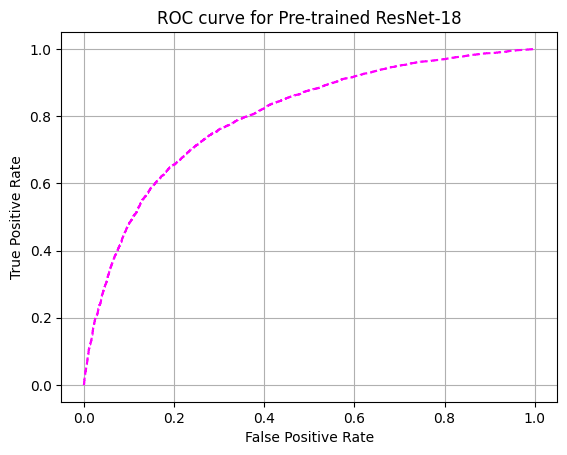

In [ ]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Pre-trained ResNet-18")
plt.show()

## IV. Swin Transformer

In [ ]:
train_loader =  DataLoader(train_set, batch_size=300, shuffle=True)
test_loader =  DataLoader(test_set, batch_size=300, shuffle=False)

In [ ]:
model_swin_t = torchvision.models.swin_t(weights=torchvision.models.Swin_T_Weights).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth


  0%|          | 0.00/108M [00:00<?, ?B/s]

In [ ]:
in_features = model_swin_t.head.in_features
model_swin_t.head = nn.Linear(in_features, 2, device=device)

In [ ]:
lr_list = [1e-5] * 5
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_swin_t.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_swin_t, criterion, optimizer)
    test_loop_Entropy(test_loader, model_swin_t, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)
path_1 = "./gdrive/MyDrive/CMS_model/swin_t_task1_weights_01.pth"
torch.save(model_swin_t.state_dict(), path_1)

-------------Epoch 1-------------
batch: [  200], loss: 0.686
temporary loss: 0.660671 | [60000/448200]
batch: [  400], loss: 0.664
temporary loss: 0.654136 | [120000/448200]
batch: [  600], loss: 0.654
temporary loss: 0.647109 | [180000/448200]
batch: [  800], loss: 0.649
temporary loss: 0.683547 | [240000/448200]
batch: [ 1000], loss: 0.644
temporary loss: 0.648290 | [300000/448200]
batch: [ 1200], loss: 0.636
temporary loss: 0.572090 | [360000/448200]
batch: [ 1400], loss: 0.630
temporary loss: 0.591263 | [420000/448200]
Test Error: 
 Accuracy: 66.0%
Avg loss: 0.620104 

-------------Epoch 2-------------
batch: [  200], loss: 0.620
temporary loss: 0.603444 | [60000/448200]
batch: [  400], loss: 0.612
temporary loss: 0.606232 | [120000/448200]
batch: [  600], loss: 0.610
temporary loss: 0.587703 | [180000/448200]
batch: [  800], loss: 0.603
temporary loss: 0.625941 | [240000/448200]
batch: [ 1000], loss: 0.601
temporary loss: 0.594695 | [300000/448200]
batch: [ 1200], loss: 0.600
tem

In [ ]:
model_swin_t.load_state_dict( torch.load("./gdrive/MyDrive/CMS_model/swin_t_task1_weights_01.pth") )
test_loop_Entropy(test_loader, model_swin_t, criterion)

Test Error: 
 Accuracy: 72.3%
Avg loss: 0.554204 



In [ ]:
lr_list = [1e-5] * 3
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_swin_t.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_swin_t, criterion, optimizer)
    test_loop_Entropy(test_loader, model_swin_t, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.559
temporary loss: 0.552785 | [60000/448200]
batch: [  400], loss: 0.558
temporary loss: 0.517629 | [120000/448200]
batch: [  600], loss: 0.560
temporary loss: 0.563873 | [180000/448200]
batch: [  800], loss: 0.561
temporary loss: 0.563988 | [240000/448200]
batch: [ 1000], loss: 0.560
temporary loss: 0.578695 | [300000/448200]
batch: [ 1200], loss: 0.559
temporary loss: 0.604318 | [360000/448200]
batch: [ 1400], loss: 0.558
temporary loss: 0.554439 | [420000/448200]
Test Error: 
 Accuracy: 72.1%
Avg loss: 0.556209 

-------------Epoch 2-------------
batch: [  200], loss: 0.556
temporary loss: 0.553019 | [60000/448200]
batch: [  400], loss: 0.550
temporary loss: 0.566771 | [120000/448200]
batch: [  600], loss: 0.558
temporary loss: 0.611165 | [180000/448200]
batch: [  800], loss: 0.554
temporary loss: 0.582566 | [240000/448200]
batch: [ 1000], loss: 0.557
temporary loss: 0.518267 | [300000/448200]
batch: [ 1200], loss: 0.554
tem

In [27]:
path_2 = "./gdrive/MyDrive/CMS_model/swin_t_task1_weights_02.pth"
torch.save(model_swin_t.state_dict(), path_2)
"""
from google.colab import runtime
runtime.unassign()
"""

'\nfrom google.colab import runtime\nruntime.unassign()\n'

### ROC-AUC (Swin Transformer)

In [28]:
total_prob_swin_t, total_label_swin_t = test_loop_prob(test_loader, model_swin_t)
fpr, tpr, thresholds = metrics.roc_curve(total_label_swin_t, total_prob_swin_t)
swin_t_AUC_1 = metrics.roc_auc_score(total_label_swin_t, total_prob_swin_t)

Process: 0.0\%
Process: 15.060240963855422\%
Process: 30.120481927710845\%
Process: 45.18072289156627\%
Process: 60.24096385542169\%
Process: 75.30120481927712\%
Process: 90.36144578313254\%


In [29]:
print("The ROC-AUC score of Pre-trained Swin Transformer (tiny) is:", swin_t_AUC_1)

The ROC-AUC score of Pre-trained Swin Transformer (tiny) is: 0.7972958309919672


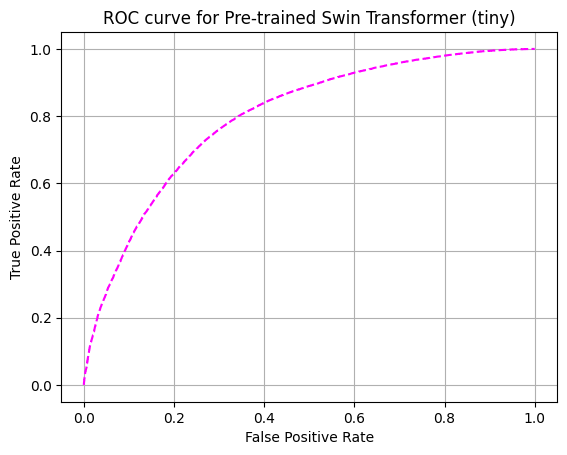

In [30]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Pre-trained Swin Transformer (tiny)")
plt.show()

## Conclusion

1. Vision Transformer: 1e-3 (5 epochs), 1e-4 (4 epochs)

Accuracy: 72.5%, ROC-AUC score: 0.80

2. Swin Transformer (tiny): 1e-5 (8 epochs)

Accuracy: 72.9%, ROC-AUC score: 0.80

They have comparable performance. However, because the training of two vision transformer type models is computational expensive, the training is not pushed to the limit.